In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
import math
import keras

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from scipy.stats import f_oneway

import warnings
warnings.filterwarnings('ignore')

data_path = 'og_data/'

train = pd.read_csv(os.path.join(data_path, 'train.csv'), parse_dates=['date'])
test = pd.read_csv(os.path.join(data_path, 'test.csv'), parse_dates=['date'])

# holidays_events = pd.read_csv(os.path.join(data_path, 'holidays_events.csv'), parse_dates=['date'])
oil = pd.read_csv(os.path.join(data_path, 'oil.csv'), parse_dates=['date'])
stores = pd.read_csv(os.path.join(data_path, 'stores.csv'))
transactions = pd.read_csv(os.path.join(data_path, 'transactions.csv'), parse_dates=['date'])
submission = pd.read_csv(os.path.join(data_path, 'sample_submission.csv'), index_col='id')

2024-08-05 17:14:13.921617: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-05 17:14:13.929426: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-05 17:14:13.996009: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-05 17:14:14.049797: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-05 17:14:14.103961: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

F-statistic: 1506.5585637191425
P-value: 0.0


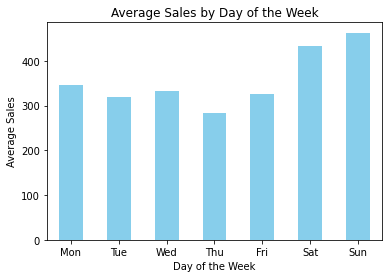

In [2]:

data = pd.read_csv(os.path.join(data_path, 'train.csv'), parse_dates=['date'])

data['dayofweek'] = data['date'].dt.dayofweek

average_sales = data.groupby('dayofweek')['sales'].mean()

average_sales.plot(kind='bar', color='skyblue')
plt.title('Average Sales by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Average Sales')
plt.xticks(range(0, 7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], rotation=0)
plt.savefig('../weekday.png')

grouped = data.groupby('dayofweek')['sales']

sales_data = [group for name, group in grouped]

f_stat, p_value = f_oneway(*sales_data)
print('F-statistic:', f_stat)
print('P-value:', p_value)

In [3]:
def nan_helper(y):
    """Helper to handle indices and logical indices of NaNs.

    Input:
        - y, 1d numpy array with possible NaNs
    Output:
        - nans, logical indices of NaNs
        - index, a function, with signature indices= index(logical_indices),
          to convert logical indices of NaNs to 'equivalent' indices
    Example:
        >>> # linear interpolation of NaNs
        >>> nans, x= nan_helper(y)
        >>> y[nans]= np.interp(x(nans), x(~nans), y[~nans])
    """

    return np.isnan(y), lambda z: z.nonzero()[0]

In [4]:
date_min, date_max = train.date.min(), test.date.max()
oil['date'] = pd.to_datetime(oil['date'])
new_df = pd.DataFrame()
new_df['date'] = pd.date_range(date_min, date_max)
new_df = pd.merge(new_df,oil, how="outer", on='date')
new_df['dcoilwtico'] = new_df['dcoilwtico'].interpolate(method = "linear")
oil = new_df

oil_prices = np.asarray(oil['dcoilwtico'])
nans, x= nan_helper(oil_prices)
oil_prices[nans]= np.interp(x(nans), x(~nans), oil_prices[~nans])
oil['dcoilwtico'] = oil_prices

In [5]:
train_data = train.copy().drop(['onpromotion'], axis=1)
test_data = test.copy().drop(['onpromotion'], axis=1)

train_data['dayofweek'] = data['date'].dt.dayofweek
test_data['dayofweek'] = data['date'].dt.dayofweek

train_data = train_data.merge(oil, on='date', how='left')
test_data = test_data.merge(oil, on='date', how='left')



# Ordinal Encoding for 'family' column
ordinal_encoder = OrdinalEncoder(dtype=int)
train_data[['family']] = ordinal_encoder.fit_transform(train_data[['family']])
test_data[['family']] = ordinal_encoder.transform(test_data[['family']])

num_days_train = train["date"].nunique()
num_stores_train = train["store_nbr"].nunique()
num_families_train = train["family"].nunique()

num_days_test = test["date"].nunique()
num_stores_test = test["store_nbr"].nunique()
num_families_test = test["family"].nunique()

pivoted_train = train_data.pivot(index=['date','dcoilwtico','dayofweek'], columns=['store_nbr', 'family'], values='sales')

train_samples = int(num_days_train * 0.95)
train_samples_df = pivoted_train[:train_samples]
valid_samples_df = pivoted_train[train_samples:]

print("\nFirst 5 rows of the original train data:")
print(train_samples_df.shape)
print(train_samples_df.head())

minmax_scaler = MinMaxScaler()
minmax_scaler.fit(train_samples_df)
scaled_train_samples = minmax_scaler.transform(train_samples_df)
scaled_validation_samples = minmax_scaler.transform(valid_samples_df)

print("\nFirst 5 rows of the original train data:")
print(scaled_train_samples.shape)
print(scaled_train_samples)


First 5 rows of the original train data:
(1599, 1782)
store_nbr                          1                                       \
family                            0    1    2       3    4        5    6    
date       dcoilwtico dayofweek                                             
2013-01-01 93.140000  1          0.0  0.0  0.0     0.0  0.0    0.000  0.0   
2013-01-02 93.140000  2          2.0  0.0  2.0  1091.0  0.0  470.652  0.0   
2013-01-03 92.970000  3          3.0  0.0  0.0   919.0  0.0  310.655  0.0   
2013-01-04 93.120000  4          3.0  0.0  3.0   953.0  0.0  198.366  0.0   
2013-01-05 93.146667  5          5.0  0.0  3.0  1160.0  0.0  301.057  0.0   

store_nbr                                                ...    9           \
family                               7      8        9   ...   23       24   
date       dcoilwtico dayofweek                          ...                 
2013-01-01 93.140000  1             0.0    0.0    0.000  ...  0.0    0.000   
2013-01-02 93.14

In [6]:
a, count, max_var = 0, 0, 20
def get_lr_callback(batch_size=8, mode='cos', epochs=10, plot=False):
    lr_start, lr_max, lr_min = 1e-2, 1e-5 * batch_size, 1e-4
    lr_ramp_ep, lr_sus_ep, lr_decay = 0, 0, 0.75
    line_max, line_min = 1, 1e-2
    
    def lrfn(epoch):  # Learning rate update function
        if epoch < lr_ramp_ep: lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
        elif epoch < lr_ramp_ep + lr_sus_ep: lr = lr_max
        elif mode == 'exp': lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
        elif mode == 'line': 
            m = (lr_min - lr_start)/epochs
            lr = m * epoch + lr_start
        elif mode == 'step': lr = lr_max * lr_decay**((epoch - lr_ramp_ep - lr_sus_ep) // 2)
        elif mode == 'cos':
            decay_total_epochs, decay_epoch_index = (epochs - lr_ramp_ep - lr_sus_ep) /(epochs/20), epoch - lr_ramp_ep - lr_sus_ep
            phase = math.pi * decay_epoch_index / decay_total_epochs
            m = (line_min - line_max)/epochs
            control = m * epoch + line_max
            lr = ((lr_start - lr_min) * (1+np.cos(phase)) + lr_min) * control
        elif mode == 'var':
            global a, count, max_var
            m = (lr_min - lr_start)/max_var
            if a < max_var:
                lr = m * (epoch-count) + lr_start
                a += 1
            elif a >= max_var:
                print(epoch-count)
                lr = m * (epoch-count) + lr_start
                count += max_var + 1
                a = 0
        return lr

    if plot:  # Plot lr curve if plot is True
        plt.figure(figsize=(10, 5))
        plt.plot(np.arange(epochs), [lrfn(epoch) for epoch in np.arange(epochs)], marker='o')
        plt.xlabel('epoch'); plt.ylabel('lr')
        plt.title('LR Scheduler')
        plt.show()

    return keras.callbacks.LearningRateScheduler(lrfn, verbose=False)  # Create lr callback

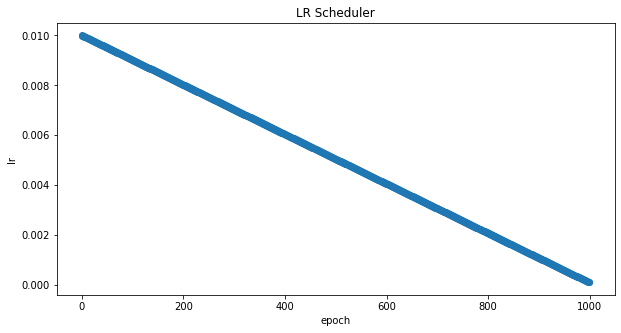

In [7]:
batch_size = 512
lr_mode = 'line'
epochs = 1000 
lr_cb = get_lr_callback(batch_size, mode=lr_mode, epochs=epochs, plot=True)

In [17]:
def split_series(series, n_past, n_future):
    X, y = [], []
    for window_start in range(len(series)):
        past_end = window_start + n_past
        future_end = past_end + n_future
        if future_end > len(series):
            break
        X.append(series[window_start:past_end, :])
        y.append(series[past_end:future_end, :])
    return np.array(X), np.array(y)

n_future = 16
n_past = scaled_validation_samples.shape[0] - n_future
n_features = num_stores_train * num_families_train

if (n_past - n_future)%2 == 0:
    crop_max = int((n_past - n_future))
else:
    crop_min = int((n_past - n_future)/2)
    crop_max = 2*crop_min + 1

X_train, y_train = split_series(scaled_train_samples, n_past, n_future)
X_val, y_val = split_series(scaled_validation_samples, n_past, n_future)

model = Sequential()
model.add(layers.SeparableConv1D(filters=512, kernel_size=(7), padding='same', input_shape=(n_past, n_features)))
model.add(layers.SeparableConv1D(filters=512, kernel_size=(7), padding='same'))
model.add(layers.SeparableConv1D(filters=512, kernel_size=(7), padding='same'))
model.add(layers.MaxPool1D(strides=1, padding='same'))
model.add(layers.SeparableConv1D(filters=1024, kernel_size=(15), padding='same'))
model.add(layers.SeparableConv1D(filters=1024, kernel_size=(15), padding='same'))
model.add(layers.SeparableConv1D(filters=1024, kernel_size=(15), padding='same'))
model.add(layers.MaxPool1D(strides=1, padding='same'))
model.add(layers.SeparableConv1D(filters=512, kernel_size=(7), padding='same'))
model.add(layers.SeparableConv1D(filters=512, kernel_size=(7), padding='same'))
model.add(layers.SeparableConv1D(filters=512, kernel_size=(7), padding='same'))
model.add(layers.MaxPool1D(strides=1, padding='same'))
model.add(layers.Bidirectional(layers.LSTM(units=256, return_sequences=True)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.Bidirectional(layers.LSTM(units=256, return_sequences=True)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.Cropping1D(cropping=(0, crop_max)))
model.add(layers.TimeDistributed(layers.Dense(n_features)))

model.compile(loss='mae', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['msle'])
model.build((None, n_past, n_features))
model.summary()

early_stopping = EarlyStopping(monitor='val_msle', min_delta=1e-4, patience=50, restore_best_weights=True)

model_history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, callbacks=[lr_cb, early_stopping], 
                          batch_size=batch_size, shuffle=False)

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ separable_conv1d_65             │ (None, 69, 512)        │     1,009,124 │
│ (SeparableConv1D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv1d_66             │ (None, 69, 512)        │       290,304 │
│ (SeparableConv1D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv1d_67             │ (None, 69, 512)        │       290,304 │
│ (SeparableConv1D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_21 (MaxPooling1D) │ (None, 69, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv1d_68             │ (None, 69, 1024)       │       552,960 │
│ (SeparableConv1D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv1d_69             │ (None, 69, 1024)       │     1,104,896 │
│ (SeparableConv1D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv1d_70             │ (None, 69, 1024)       │     1,104,896 │
│ (SeparableConv1D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_22 (MaxPooling1D) │ (None, 69, 1024)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv1d_71             │ (None, 69, 512)        │       580,096 │
│ (SeparableConv1D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv1d_72             │ (None, 69, 512)        │       290,304 │
│ (SeparableConv1D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv1d_73             │ (None, 69, 512)        │       290,304 │
│ (SeparableConv1D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_23 (MaxPooling1D) │ (None, 69, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_14                │ (None, 69, 512)        │     1,574,912 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 69, 512)        │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 69, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_15                │ (None, 69, 512)        │     1,574,912 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 69, 512)        │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 69, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 9,581,274 (36.55 MB)

 Trainable params: 9,579,226 (36.54 MB)

 Non-trainable params: 2,048 (8.00 KB)

Epoch 1/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 52s 12s/step - loss: 0.3694 - msle: 0.0764 - val_loss: 0.2486 - val_msle: 0.0424 - learning_rate: 0.0100
Epoch 2/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 44s 13s/step - loss: 1.3090 - msle: 0.2840 - val_loss: 0.8313 - val_msle: 0.1333 - learning_rate: 0.0100
Epoch 3/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 46s 14s/step - loss: 1.8676 - msle: 0.4225 - val_loss: 0.8864 - val_msle: 0.1118 - learning_rate: 0.0100
Epoch 4/1000


2024-08-05 17:21:49.891282: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 310210560 bytes after encountering the first element of size 310210560 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


3/3 ━━━━━━━━━━━━━━━━━━━━ 72s 13s/step - loss: 1.6697 - msle: 0.3167 - val_loss: 0.7203 - val_msle: 0.0978 - learning_rate: 0.0100
Epoch 5/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 34s 11s/step - loss: 0.7670 - msle: 0.1715 - val_loss: 1.3330 - val_msle: 0.2595 - learning_rate: 0.0100
Epoch 6/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 35s 11s/step - loss: 1.1720 - msle: 0.2717 - val_loss: 1.0394 - val_msle: 0.1961 - learning_rate: 0.0100
Epoch 7/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 35s 12s/step - loss: 1.0132 - msle: 0.2095 - val_loss: 0.4718 - val_msle: 0.0697 - learning_rate: 0.0099
Epoch 8/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 35s 12s/step - loss: 0.8285 - msle: 0.2141 - val_loss: 0.5149 - val_msle: 0.0828 - learning_rate: 0.0099
Epoch 9/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 36s 12s/step - loss: 0.7764 - msle: 0.1964 - val_loss: 0.5244 - val_msle: 0.0792 - learning_rate: 0.0099
Epoch 10/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 36s 12s/step - loss: 0.4995 - msle: 0.1095 - val_loss: 0.5860 - val_msle: 0.0830 - learning_rate: 0.0099
Epoch 11/10

2024-08-05 17:25:56.479018: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 310210560 bytes after encountering the first element of size 310210560 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


3/3 ━━━━━━━━━━━━━━━━━━━━ 36s 12s/step - loss: 1.0306 - msle: 0.2864 - val_loss: 0.9817 - val_msle: 0.1207 - learning_rate: 0.0099
Epoch 12/1000


2024-08-05 17:26:32.009558: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 310210560 bytes after encountering the first element of size 310210560 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


3/3 ━━━━━━━━━━━━━━━━━━━━ 36s 12s/step - loss: 1.0906 - msle: 0.2441 - val_loss: 0.6365 - val_msle: 0.1068 - learning_rate: 0.0099
Epoch 13/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 36s 12s/step - loss: 0.8050 - msle: 0.1696 - val_loss: 0.6329 - val_msle: 0.0957 - learning_rate: 0.0099
Epoch 14/1000


2024-08-05 17:27:43.280659: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 310210560 bytes after encountering the first element of size 310210560 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


3/3 ━━━━━━━━━━━━━━━━━━━━ 36s 12s/step - loss: 0.9203 - msle: 0.1623 - val_loss: 0.5205 - val_msle: 0.1103 - learning_rate: 0.0099
Epoch 15/1000


2024-08-05 17:28:19.296003: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 310210560 bytes after encountering the first element of size 310210560 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


3/3 ━━━━━━━━━━━━━━━━━━━━ 36s 12s/step - loss: 1.2827 - msle: 0.3352 - val_loss: 0.5080 - val_msle: 0.0885 - learning_rate: 0.0099
Epoch 16/1000


2024-08-05 17:28:55.502667: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 310210560 bytes after encountering the first element of size 310210560 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


3/3 ━━━━━━━━━━━━━━━━━━━━ 36s 12s/step - loss: 1.1696 - msle: 0.2781 - val_loss: 0.7397 - val_msle: 0.1614 - learning_rate: 0.0099
Epoch 17/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 36s 12s/step - loss: 0.5983 - msle: 0.1369 - val_loss: 0.4819 - val_msle: 0.0939 - learning_rate: 0.0098
Epoch 18/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 36s 12s/step - loss: 0.4460 - msle: 0.0942 - val_loss: 0.4255 - val_msle: 0.0733 - learning_rate: 0.0098
Epoch 19/1000


2024-08-05 17:30:44.291422: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 310210560 bytes after encountering the first element of size 310210560 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


3/3 ━━━━━━━━━━━━━━━━━━━━ 36s 12s/step - loss: 0.3742 - msle: 0.0718 - val_loss: 0.3852 - val_msle: 0.0660 - learning_rate: 0.0098
Epoch 20/1000


2024-08-05 17:31:20.780429: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 310210560 bytes after encountering the first element of size 310210560 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


3/3 ━━━━━━━━━━━━━━━━━━━━ 36s 12s/step - loss: 0.3682 - msle: 0.0723 - val_loss: 0.3753 - val_msle: 0.0634 - learning_rate: 0.0098
Epoch 21/1000


2024-08-05 17:31:56.975287: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 310210560 bytes after encountering the first element of size 310210560 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


3/3 ━━━━━━━━━━━━━━━━━━━━ 36s 12s/step - loss: 0.3566 - msle: 0.0708 - val_loss: 0.3407 - val_msle: 0.0580 - learning_rate: 0.0098
Epoch 22/1000


2024-08-05 17:32:33.244649: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 310210560 bytes after encountering the first element of size 310210560 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


3/3 ━━━━━━━━━━━━━━━━━━━━ 36s 12s/step - loss: 0.3103 - msle: 0.0575 - val_loss: 0.3213 - val_msle: 0.0545 - learning_rate: 0.0098
Epoch 23/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 36s 12s/step - loss: 0.2826 - msle: 0.0512 - val_loss: 0.3179 - val_msle: 0.0541 - learning_rate: 0.0098
Epoch 24/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 36s 12s/step - loss: 0.2644 - msle: 0.0471 - val_loss: 0.3153 - val_msle: 0.0541 - learning_rate: 0.0098
Epoch 25/1000


2024-08-05 17:34:21.656052: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 310210560 bytes after encountering the first element of size 310210560 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


3/3 ━━━━━━━━━━━━━━━━━━━━ 36s 12s/step - loss: 0.2444 - msle: 0.0420 - val_loss: 0.3102 - val_msle: 0.0530 - learning_rate: 0.0098
Epoch 26/1000


2024-08-05 17:34:57.540217: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 310210560 bytes after encountering the first element of size 310210560 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


3/3 ━━━━━━━━━━━━━━━━━━━━ 36s 12s/step - loss: 0.2251 - msle: 0.0370 - val_loss: 0.3030 - val_msle: 0.0517 - learning_rate: 0.0098
Epoch 27/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 36s 12s/step - loss: 0.2152 - msle: 0.0355 - val_loss: 0.2903 - val_msle: 0.0490 - learning_rate: 0.0097
Epoch 28/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 36s 12s/step - loss: 0.2024 - msle: 0.0327 - val_loss: 0.2775 - val_msle: 0.0463 - learning_rate: 0.0097
Epoch 29/1000


2024-08-05 17:36:45.388451: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 310210560 bytes after encountering the first element of size 310210560 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


3/3 ━━━━━━━━━━━━━━━━━━━━ 36s 12s/step - loss: 0.1884 - msle: 0.0295 - val_loss: 0.2645 - val_msle: 0.0435 - learning_rate: 0.0097
Epoch 30/1000


2024-08-05 17:37:21.121892: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 310210560 bytes after encountering the first element of size 310210560 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


3/3 ━━━━━━━━━━━━━━━━━━━━ 36s 12s/step - loss: 0.1792 - msle: 0.0275 - val_loss: 0.2508 - val_msle: 0.0407 - learning_rate: 0.0097
Epoch 31/1000


2024-08-05 17:37:57.102736: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 310210560 bytes after encountering the first element of size 310210560 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


3/3 ━━━━━━━━━━━━━━━━━━━━ 36s 12s/step - loss: 0.1711 - msle: 0.0260 - val_loss: 0.2376 - val_msle: 0.0380 - learning_rate: 0.0097
Epoch 32/1000


2024-08-05 17:38:32.992366: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 310210560 bytes after encountering the first element of size 310210560 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


3/3 ━━━━━━━━━━━━━━━━━━━━ 36s 12s/step - loss: 0.1637 - msle: 0.0245 - val_loss: 0.2285 - val_msle: 0.0361 - learning_rate: 0.0097
Epoch 33/1000


2024-08-05 17:39:08.987159: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 310210560 bytes after encountering the first element of size 310210560 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


3/3 ━━━━━━━━━━━━━━━━━━━━ 36s 12s/step - loss: 0.1566 - msle: 0.0230 - val_loss: 0.2192 - val_msle: 0.0343 - learning_rate: 0.0097
Epoch 34/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 36s 12s/step - loss: 0.1494 - msle: 0.0215 - val_loss: 0.2110 - val_msle: 0.0327 - learning_rate: 0.0097
Epoch 35/1000


2024-08-05 17:40:20.977716: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 310210560 bytes after encountering the first element of size 310210560 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


3/3 ━━━━━━━━━━━━━━━━━━━━ 36s 12s/step - loss: 0.2094 - msle: 0.0345 - val_loss: 0.5088 - val_msle: 0.0972 - learning_rate: 0.0097
Epoch 36/1000


2024-08-05 17:40:57.379829: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 310210560 bytes after encountering the first element of size 310210560 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


3/3 ━━━━━━━━━━━━━━━━━━━━ 37s 12s/step - loss: 0.5938 - msle: 0.1365 - val_loss: 0.5590 - val_msle: 0.1200 - learning_rate: 0.0097
Epoch 37/1000


2024-08-05 17:41:33.928938: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 310210560 bytes after encountering the first element of size 310210560 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


3/3 ━━━━━━━━━━━━━━━━━━━━ 37s 12s/step - loss: 0.8089 - msle: 0.2098 - val_loss: 1.1675 - val_msle: 0.2259 - learning_rate: 0.0096
Epoch 38/1000


2024-08-05 17:42:10.447927: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 310210560 bytes after encountering the first element of size 310210560 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


3/3 ━━━━━━━━━━━━━━━━━━━━ 37s 12s/step - loss: 1.2985 - msle: 0.3019 - val_loss: 0.5319 - val_msle: 0.0946 - learning_rate: 0.0096
Epoch 39/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 36s 12s/step - loss: 0.6973 - msle: 0.1391 - val_loss: 0.5273 - val_msle: 0.0901 - learning_rate: 0.0096
Epoch 40/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 37s 12s/step - loss: 0.4403 - msle: 0.0959 - val_loss: 0.4779 - val_msle: 0.0833 - learning_rate: 0.0096
Epoch 41/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 36s 12s/step - loss: 0.2723 - msle: 0.0497 - val_loss: 0.4508 - val_msle: 0.0782 - learning_rate: 0.0096
Epoch 42/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 36s 12s/step - loss: 0.3817 - msle: 0.0570 - val_loss: 0.6598 - val_msle: 0.0958 - learning_rate: 0.0096
Epoch 43/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 36s 12s/step - loss: 0.5487 - msle: 0.0815 - val_loss: 0.4110 - val_msle: 0.0696 - learning_rate: 0.0096
Epoch 44/1000


2024-08-05 17:45:48.480172: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 310210560 bytes after encountering the first element of size 310210560 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


3/3 ━━━━━━━━━━━━━━━━━━━━ 36s 12s/step - loss: 0.4668 - msle: 0.1175 - val_loss: 0.4767 - val_msle: 0.0773 - learning_rate: 0.0096
Epoch 45/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 36s 12s/step - loss: 0.3437 - msle: 0.0631 - val_loss: 0.3994 - val_msle: 0.0618 - learning_rate: 0.0096
Epoch 46/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 36s 12s/step - loss: 0.3134 - msle: 0.0615 - val_loss: 0.3891 - val_msle: 0.0623 - learning_rate: 0.0096
Epoch 47/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 36s 12s/step - loss: 0.2692 - msle: 0.0478 - val_loss: 0.4114 - val_msle: 0.0643 - learning_rate: 0.0095
Epoch 48/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 36s 12s/step - loss: 0.3986 - msle: 0.0737 - val_loss: 0.3231 - val_msle: 0.0532 - learning_rate: 0.0095
Epoch 49/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 36s 12s/step - loss: 0.3585 - msle: 0.0737 - val_loss: 0.3111 - val_msle: 0.0509 - learning_rate: 0.0095
Epoch 50/1000


2024-08-05 17:49:24.091927: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 310210560 bytes after encountering the first element of size 310210560 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


3/3 ━━━━━━━━━━━━━━━━━━━━ 36s 12s/step - loss: 0.3347 - msle: 0.0635 - val_loss: 0.3457 - val_msle: 0.0540 - learning_rate: 0.0095
Epoch 51/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 37s 12s/step - loss: 0.3339 - msle: 0.0633 - val_loss: 0.3398 - val_msle: 0.0551 - learning_rate: 0.0095
Epoch 52/1000


2024-08-05 17:50:37.033562: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 310210560 bytes after encountering the first element of size 310210560 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


3/3 ━━━━━━━━━━━━━━━━━━━━ 37s 12s/step - loss: 0.3254 - msle: 0.0599 - val_loss: 0.3286 - val_msle: 0.0537 - learning_rate: 0.0095
Epoch 53/1000


2024-08-05 17:51:13.550612: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 310210560 bytes after encountering the first element of size 310210560 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


3/3 ━━━━━━━━━━━━━━━━━━━━ 36s 12s/step - loss: 0.3036 - msle: 0.0574 - val_loss: 0.3589 - val_msle: 0.0576 - learning_rate: 0.0095
Epoch 54/1000


2024-08-05 17:51:49.827346: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 310210560 bytes after encountering the first element of size 310210560 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


3/3 ━━━━━━━━━━━━━━━━━━━━ 36s 12s/step - loss: 0.2693 - msle: 0.0475 - val_loss: 0.3714 - val_msle: 0.0592 - learning_rate: 0.0095
Epoch 55/1000


2024-08-05 17:52:26.200420: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 310210560 bytes after encountering the first element of size 310210560 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


3/3 ━━━━━━━━━━━━━━━━━━━━ 36s 12s/step - loss: 0.2035 - msle: 0.0322 - val_loss: 0.4936 - val_msle: 0.0801 - learning_rate: 0.0095
Epoch 56/1000


2024-08-05 17:53:02.687717: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 310210560 bytes after encountering the first element of size 310210560 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


3/3 ━━━━━━━━━━━━━━━━━━━━ 36s 12s/step - loss: 0.3972 - msle: 0.0778 - val_loss: 0.5679 - val_msle: 0.0774 - learning_rate: 0.0095
Epoch 57/1000


2024-08-05 17:53:38.625341: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 310210560 bytes after encountering the first element of size 310210560 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


3/3 ━━━━━━━━━━━━━━━━━━━━ 36s 12s/step - loss: 0.4909 - msle: 0.0767 - val_loss: 0.2886 - val_msle: 0.0472 - learning_rate: 0.0094
Epoch 58/1000


2024-08-05 17:54:14.430784: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 310210560 bytes after encountering the first element of size 310210560 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


3/3 ━━━━━━━━━━━━━━━━━━━━ 36s 12s/step - loss: 0.3354 - msle: 0.0623 - val_loss: 0.3934 - val_msle: 0.0592 - learning_rate: 0.0094
Epoch 59/1000


2024-08-05 17:54:50.417338: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 310210560 bytes after encountering the first element of size 310210560 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


3/3 ━━━━━━━━━━━━━━━━━━━━ 36s 12s/step - loss: 0.2805 - msle: 0.0491 - val_loss: 0.3728 - val_msle: 0.0572 - learning_rate: 0.0094
Epoch 60/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 36s 12s/step - loss: 0.2393 - msle: 0.0422 - val_loss: 0.4843 - val_msle: 0.0675 - learning_rate: 0.0094
Epoch 61/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 36s 12s/step - loss: 0.3059 - msle: 0.0502 - val_loss: 0.7652 - val_msle: 0.1126 - learning_rate: 0.0094
Epoch 62/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 36s 12s/step - loss: 0.3149 - msle: 0.0519 - val_loss: 0.8444 - val_msle: 0.1375 - learning_rate: 0.0094
Epoch 63/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 36s 12s/step - loss: 0.6201 - msle: 0.1260 - val_loss: 0.6399 - val_msle: 0.1209 - learning_rate: 0.0094
Epoch 64/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 36s 12s/step - loss: 1.0393 - msle: 0.2900 - val_loss: 0.2388 - val_msle: 0.0383 - learning_rate: 0.0094
Epoch 65/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 36s 12s/step - loss: 0.4079 - msle: 0.0734 - val_loss: 0.4796 - val_msle: 0.0773 - learning_rate: 0.0094
Epoch 

2024-08-05 18:00:48.606701: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 310210560 bytes after encountering the first element of size 310210560 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


3/3 ━━━━━━━━━━━━━━━━━━━━ 36s 12s/step - loss: 0.3672 - msle: 0.0696 - val_loss: 0.2721 - val_msle: 0.0461 - learning_rate: 0.0093
Epoch 70/1000


2024-08-05 18:01:24.429137: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 310210560 bytes after encountering the first element of size 310210560 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


3/3 ━━━━━━━━━━━━━━━━━━━━ 36s 12s/step - loss: 0.2917 - msle: 0.0523 - val_loss: 0.3377 - val_msle: 0.0602 - learning_rate: 0.0093
Epoch 71/1000


2024-08-05 18:02:00.428489: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 310210560 bytes after encountering the first element of size 310210560 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


3/3 ━━━━━━━━━━━━━━━━━━━━ 37s 12s/step - loss: 0.2925 - msle: 0.0524 - val_loss: 0.4169 - val_msle: 0.0797 - learning_rate: 0.0093
Epoch 72/1000


2024-08-05 18:02:37.034992: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 310210560 bytes after encountering the first element of size 310210560 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


3/3 ━━━━━━━━━━━━━━━━━━━━ 36s 12s/step - loss: 0.3112 - msle: 0.0603 - val_loss: 0.4784 - val_msle: 0.0940 - learning_rate: 0.0093
Epoch 73/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 37s 12s/step - loss: 0.3125 - msle: 0.0612 - val_loss: 0.4924 - val_msle: 0.0936 - learning_rate: 0.0093
Epoch 74/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 42s 14s/step - loss: 0.2802 - msle: 0.0523 - val_loss: 0.4534 - val_msle: 0.0849 - learning_rate: 0.0093
Epoch 75/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 39s 13s/step - loss: 0.2574 - msle: 0.0472 - val_loss: 0.4109 - val_msle: 0.0736 - learning_rate: 0.0093
Epoch 76/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 37s 12s/step - loss: 0.2288 - msle: 0.0394 - val_loss: 0.4014 - val_msle: 0.0724 - learning_rate: 0.0093
Epoch 77/1000


2024-08-05 18:05:47.607767: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 310210560 bytes after encountering the first element of size 310210560 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


3/3 ━━━━━━━━━━━━━━━━━━━━ 37s 12s/step - loss: 0.2126 - msle: 0.0357 - val_loss: 0.3825 - val_msle: 0.0673 - learning_rate: 0.0092
Epoch 78/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 37s 12s/step - loss: 0.1955 - msle: 0.0314 - val_loss: 0.3635 - val_msle: 0.0629 - learning_rate: 0.0092
Epoch 79/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 37s 12s/step - loss: 0.1845 - msle: 0.0291 - val_loss: 0.3471 - val_msle: 0.0598 - learning_rate: 0.0092
Epoch 80/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 37s 12s/step - loss: 0.1739 - msle: 0.0268 - val_loss: 0.3235 - val_msle: 0.0548 - learning_rate: 0.0092
Epoch 81/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 37s 12s/step - loss: 0.1647 - msle: 0.0249 - val_loss: 0.3030 - val_msle: 0.0511 - learning_rate: 0.0092
Epoch 82/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 38s 13s/step - loss: 0.1560 - msle: 0.0231 - val_loss: 0.2850 - val_msle: 0.0480 - learning_rate: 0.0092
Epoch 83/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 38s 13s/step - loss: 0.1496 - msle: 0.0219 - val_loss: 0.2737 - val_msle: 0.0457 - learning_rate: 0.0092
Epoch 

In [18]:
x_test_pred = scaled_validation_samples[-n_past:].reshape((1, n_past, n_features))
scaled_y_predict = model.predict(x_test_pred)

y_predict = pd.DataFrame(minmax_scaler.inverse_transform(scaled_y_predict.reshape((n_future, n_features))), columns=valid_samples_df.columns)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step


In [19]:
pivoted_test = test_data.pivot(index=['date','dcoilwtico','dayofweek'], columns=['store_nbr', 'family'], values='id')

for day_ith, day_ith_pred in y_predict.iterrows():
    for n_samples_per_day in range(len(day_ith_pred)):
        sample_id = pivoted_test.iloc[[day_ith], [n_samples_per_day]].values[0][0]
        values = max(0, day_ith_pred.values[n_samples_per_day])
        submission.at[sample_id, 'sales'] = max(0, day_ith_pred.values[n_samples_per_day])

submission.to_csv('submission.csv')
print("\nFirst 5 rows of the data:")
print(submission.head())


First 5 rows of the data:
               sales
id                  
3000888     2.882082
3000889     0.000000
3000890     1.727063
3000891  2082.949463
3000892     0.930780
